In [29]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy.spatial.distance import cdist
from time import time

In [30]:
def calculate_average(*args,**kwargs):
    return np.mean(args)

In [31]:
def calculate_cost(data: np.ndarray) -> np.ndarray:
    costs = cdist(data[:,2].reshape(-1,1), data[:,2].reshape(-1,1),calculate_average)
    distances = np.round(cdist(data[:,:2], data[:,:2], 'euclidean'))
    distances = distances + costs
    return distances

In [32]:
def get_match_node(edge1: list, edge2: list) -> list:
    intersection = set(edge1).intersection(set( edge2))
    return list(intersection)

In [33]:
def sort_edges(edges: list) -> list:
    edges_sorted = [edges.pop(0)]
    last_edge = edges_sorted[-1]
    number_of_edges = len(edges)
    while len(edges_sorted) != number_of_edges:
        index = 0
        while len(edges) > index:
            matching_node = get_match_node(last_edge, edges[index])
            if matching_node:
                matching_node = matching_node[0]
                last_edge = last_edge if matching_node == last_edge[1] else last_edge[::-1]
                edge = edges.pop(index)
                edge = edge if last_edge[1] == edge[0] else edge[::-1]
                edges_sorted[-1] = last_edge
                edges_sorted.append(edge)
                last_edge = edges_sorted[-1]
                break
            index+=1
    edges_sorted.append(edges.pop(0))
    return edges_sorted

In [34]:
def choose_node_regret_weighted(distances:np.ndarray,edges:list,available_nodes:set,weight: float = 0.5) -> tuple:
    costs = []
    edges = np.array(edges)
    k = 0 if edges.shape[0] < 2 else 1
    for node_index in available_nodes:
        node_costs = distances[node_index][edges].sum(axis=1) - distances[edges[:,0],edges[:,1]]
        indicies = node_costs.argsort()
        regret = abs(node_costs[indicies[0]] - node_costs[indicies[k]])
        regret = weight*regret - (1-weight)*node_costs[indicies[0]]
        costs.append([regret,indicies[0],node_index])
    costs = np.array(costs)
    _,edges_index,new_node_index = costs[costs[:,0].argmax()]
    new_node_index = int(new_node_index)
    cost = distances[int(new_node_index)][edges[int(edges_index)]].sum() - distances[edges[int(edges_index)][0],edges[int(edges_index)][1]]
    return cost, int(new_node_index), int(edges_index)

In [35]:
def greedy_cycle(data,node_index:int,weight:float=1):
    distances = calculate_cost(data)
    visited,edges = [],[]
    limit = len(data) // 2
    cost = data[node_index][-1]
    all_nodes = set(range(len(data)))
    value = cost
    edges.append([node_index,node_index])
    visited.append(node_index)
    while(len(visited) < limit):
        cost, new_node_index,best_new_node_index = choose_node_regret_weighted(distances=distances,
                                   edges=edges,
                                   available_nodes=all_nodes.difference(set(visited)),
                                   weight=weight)
        value+=cost
        visited.append(int(new_node_index))
        parent_nodes = edges.pop(best_new_node_index)
        edges += [[parent_nodes[0],int(new_node_index)],[parent_nodes[1],int(new_node_index)]]
    edges = sort_edges(edges=edges)
    path = data[np.array(edges).flatten()]
    return value, path

In [36]:
def evaluate(func, data, n=200,weight:float = 1.0):
    total, worst_value, best_value, best_solution = 0, 0, float('inf'), None
    total_time, worst_time, best_time = 0,0,float('inf')
    for node_index in tqdm(range(n)):
        start = time()
        value, solution = func(data,node_index,weight)
        elapsed = time() - start
        total_time += elapsed
        if elapsed < best_time:
            best_time = elapsed
        worst_time = max(worst_time, elapsed)


        total += value
        if value < best_value:
            best_solution = solution
            best_value = value
        worst_value = max(worst_value, value)

    return dict(average_score=total / n,
                worst_score=worst_value,
                best_score=best_value,
                solution=np.array(best_solution).T,
                average_time=total_time / n,
                worst_time= worst_time,
                best_time = best_time)

In [37]:
def summarize(func, data, title,weight:float = 1.0):
    evaluation_results = evaluate(func=func,
                                                           data=data,
                                                           weight=weight)
    (x, y, z) = evaluation_results["solution"]
    print(f'{title}:')
    print(f'average time: {evaluation_results["average_time"]}\tworst time: {evaluation_results["worst_time"]}\tbest time: {evaluation_results["best_time"]}')

    print(f'average score: {evaluation_results["average_score"]}\tworst score: {evaluation_results["worst_score"]}\tbest score: {evaluation_results["best_score"]}')
    print('Best solution:')

    plt.figure(figsize=(15,10))
    plt.scatter(data[:,0], data[:,1], np.full(x.size, 100), data[:,2], cmap='gray_r')
    plt.clim(0, 2000)
    plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
    plt.plot(x, y, 'r')
    plt.xlim([-100, 4100])
    plt.ylim([-100, 2100])
    plt.title(title)
    plt.show()

In [38]:
data = np.loadtxt('TSPA.csv', dtype=int, delimiter=';')

Greedy cycle:
average time: 0.26781440258026123	worst time: 0.4269881248474121	best time: 0.223707914352417
average score: 117178.57	worst score: 124855.0	best score: 110218.0
Best solution:


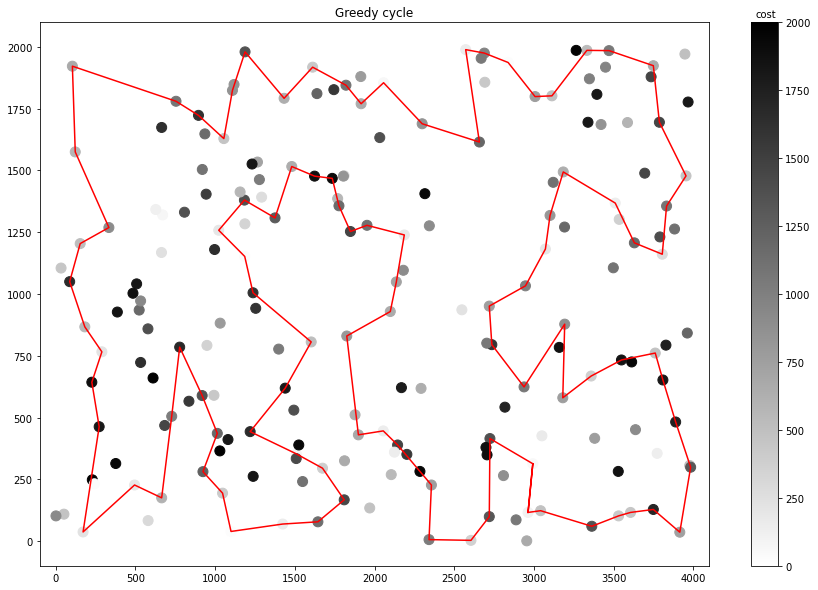

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average time: 0.2504124617576599	worst time: 0.34177374839782715	best time: 0.2290189266204834
average score: 117178.57	worst score: 124855.0	best score: 110218.0
Best solution:


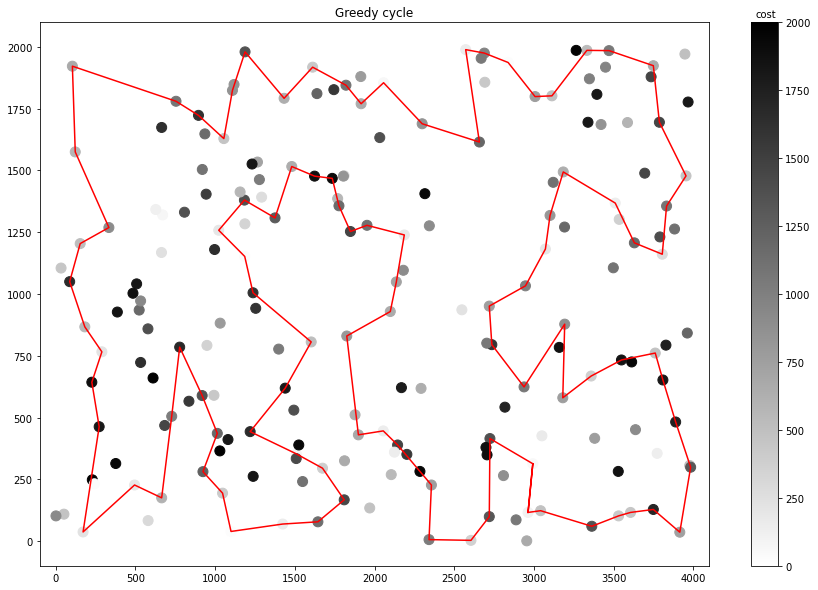

In [39]:
summarize(greedy_cycle, data, 'Greedy cycle',weight=1)

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average time: 0.2675426387786865	worst time: 0.3595409393310547	best time: 0.23559284210205078
average score: 76349.965	worst score: 78976.0	best score: 74563.0
Best solution:


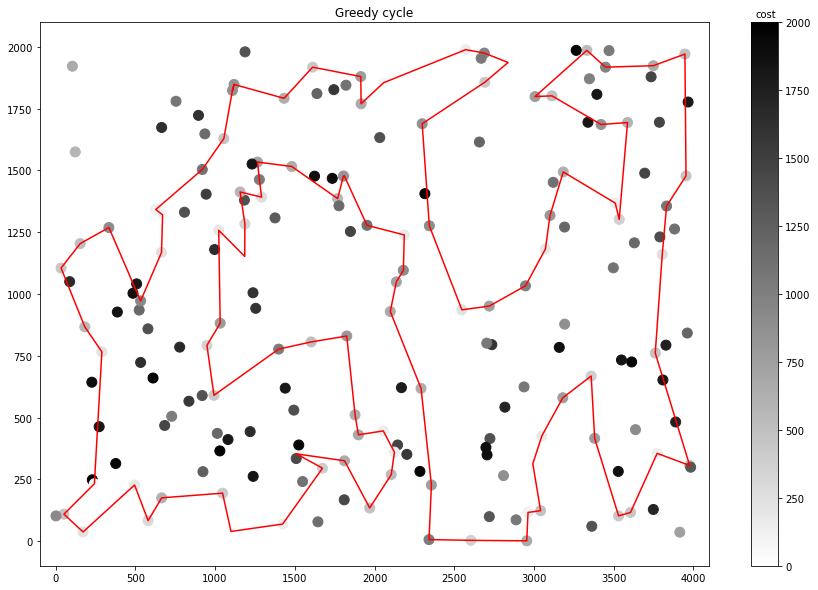

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average time: 0.24205114364624022	worst time: 0.31294679641723633	best time: 0.22586917877197266
average score: 76349.965	worst score: 78976.0	best score: 74563.0
Best solution:


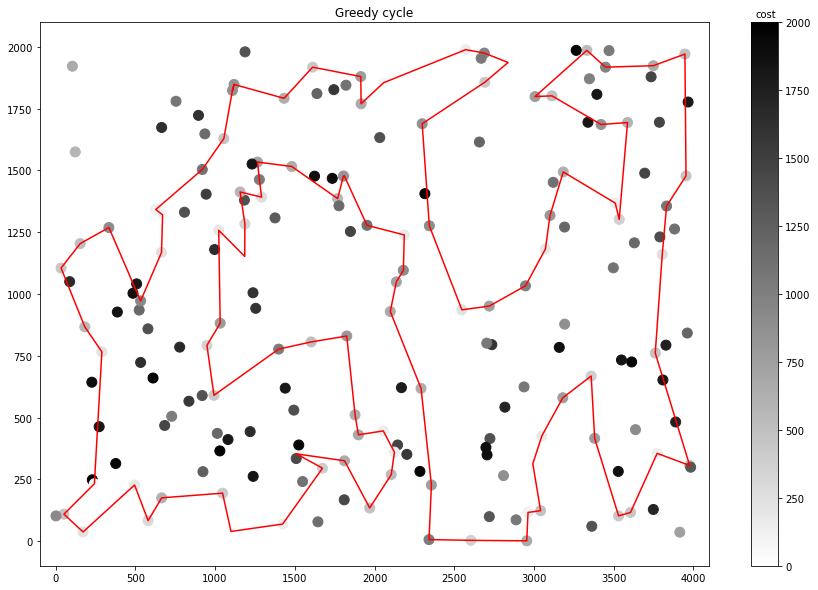

In [40]:
summarize(greedy_cycle, data, 'Greedy cycle',weight=0.5)

In [41]:
data = np.loadtxt('TSPB.csv', dtype=int, delimiter=';')

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average time: 0.25454997181892397	worst time: 0.3211650848388672	best time: 0.22939395904541016
average score: 121592.715	worst score: 131138.0	best score: 111115.0
Best solution:


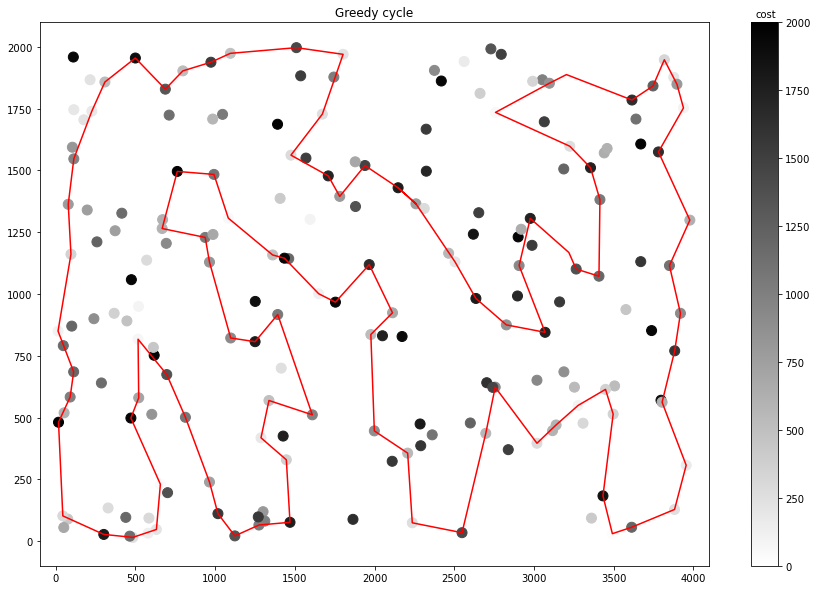

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average time: 0.24486457467079162	worst time: 0.3463938236236572	best time: 0.22544598579406738
average score: 121592.715	worst score: 131138.0	best score: 111115.0
Best solution:


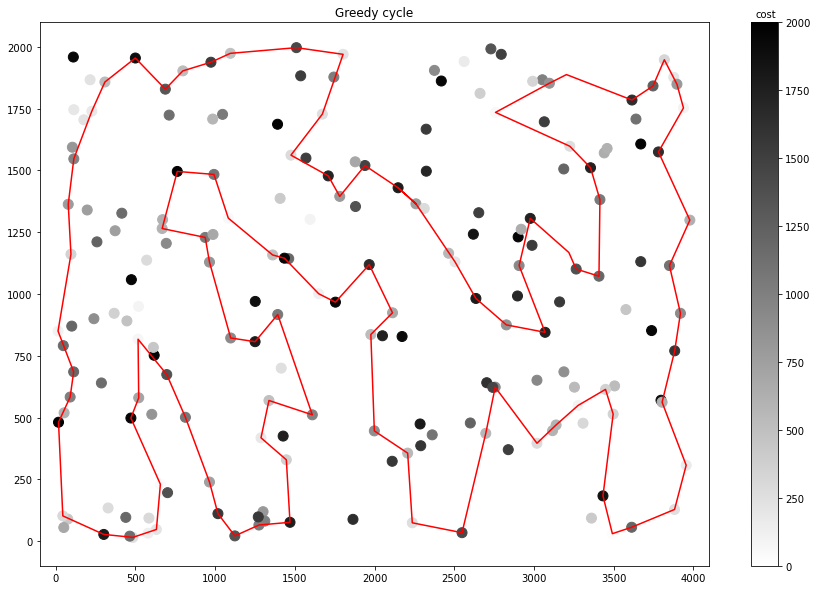

In [42]:
summarize(greedy_cycle, data, 'Greedy cycle',weight=1)

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average time: 0.24405829548835756	worst time: 0.4074549674987793	best time: 0.22606420516967773
average score: 71790.85	worst score: 77676.0	best score: 70153.0
Best solution:


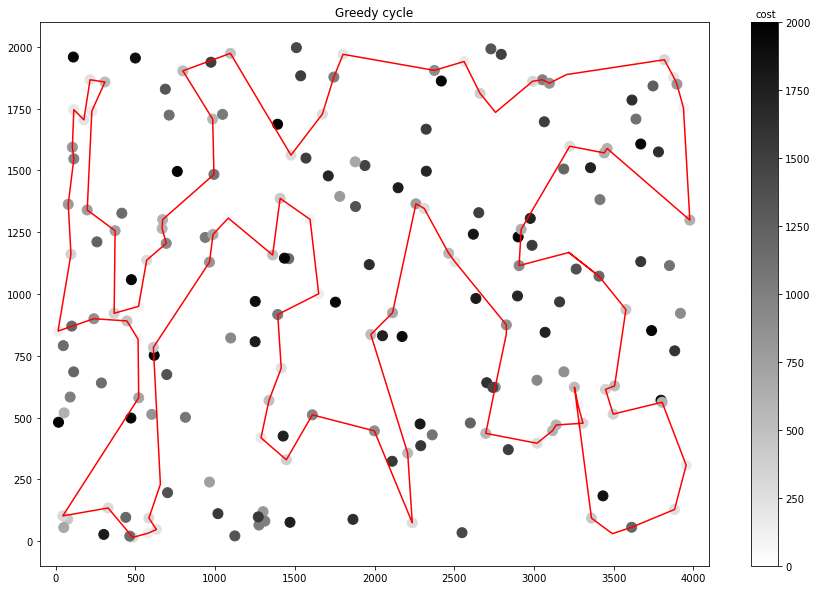

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average time: 0.23853884816169738	worst time: 0.2888190746307373	best time: 0.22378206253051758
average score: 71790.85	worst score: 77676.0	best score: 70153.0
Best solution:


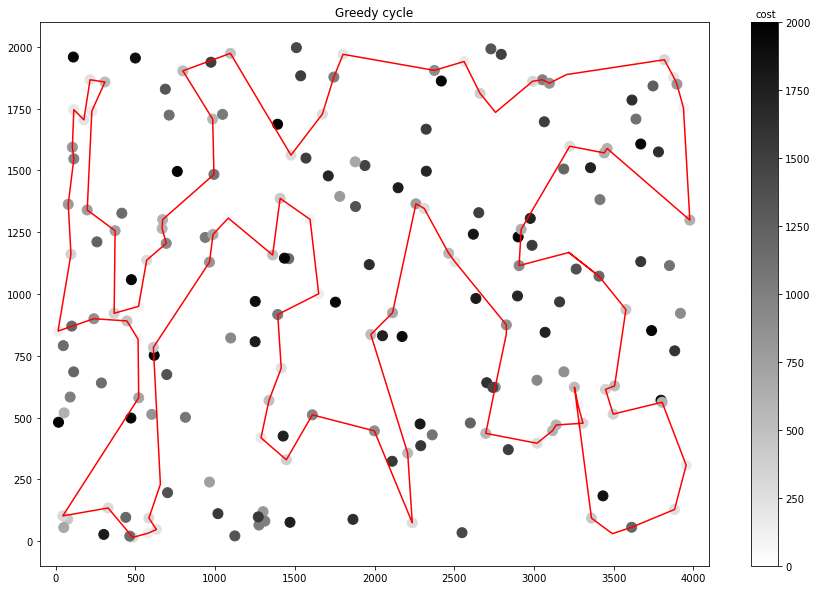

In [43]:
summarize(greedy_cycle, data, 'Greedy cycle',weight=0.5)